In [1]:
import spikeinterface.full as si
import numpy as np
import pandas as pd
from pathlib import Path
from spikeinterface.generation.drift_tools import DriftingTemplates, interpolate_templates, InjectDriftingTemplatesRecording
import pickle
import matplotlib.pyplot as plt
import scipy
from ibldsp.utils import make_channel_index
from neuropixel import trace_header
import dartsort
from dartsort.util.hybrid_util import refractory_poisson_spike_train, get_drifty_hybrid_recording
from dartsort.util.data_util import DARTsortSorting
from spikeinterface.extractors import NumpySorting
from spikeinterface.core import Templates

In [2]:

### RE recordings (destriped)

pids = [
        "1e176f17-d00f-49bb-87ff-26d237b525f1",
        "8ca1a850-26ef-42be-8b28-c2e2d12f06d6",
        "c4f6665f-8be5-476b-a6e8-d81eeae9279d",
        "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
        "e31b4e39-e350-47a9-aca4-72496d99ff2a",
       ]

def rec_from_pid(pid):
    recordings_path = Path("/expanse/lustre/projects/col168/cwindolf/rs_f16")
    ppath = recordings_path.joinpath(pid)
    return si.read_binary_folder(ppath)

In [3]:
### RE templates


temp_pids = ['1a60a6e1-da99-4d4e-a734-39b1d4544fad',
 'bbe6ebc1-d32f-42dd-a89c-211226737deb',
 '84fd7fa3-6c2d-4233-b265-46a427d3d68d',
 'dab512bd-a02d-4c1f-8dbc-9155a163efc0',
 '6fc4d73c-2071-43ec-a756-c6c6d8322c8b',
 '1f5d62cb-814f-4ab2-b6af-7557ea04d56a',
 '8ca1a850-26ef-42be-8b28-c2e2d12f06d6',
 'ad714133-1e03-4d3a-8427-33fc483daf1a',
 'c17772a9-21b5-49df-ab31-3017addea12e',
 'ce397420-3cd2-4a55-8fd1-5e28321981f4',
 '7a620688-66cb-44d3-b79b-ccac1c8ba23e']

def templates_from_pid(pid):
    templates_path = Path("/expanse/lustre/projects/col168/clangfield/data/re_templates/")
    tpath = templates_path.joinpath(pid, "templates.npy")
    z = np.load(tpath)
    return z

def template_info_from_pid(pid):
    templates_path = Path("/expanse/lustre/projects/col168/clangfield/data/re_templates/")
    tpath = templates_path.joinpath(pid, "templates.npy")
    t = pd.read_parquet(templates_path.joinpath(pid, "template_info.pqt"))
    df = pd.DataFrame(t.groupby("cluster").agg(num_wfs=("sample", "count"), peak_channel=("peak_channel", pd.Series.mode)))
    df.rename(columns = {"sample": "num_wfs"}, inplace=True)
    df["peak_channel"] = df["peak_channel"].astype(int)
    return df

In [4]:
### Motion estimates


motion_pids = ["1e176f17-d00f-49bb-87ff-26d237b525f1",
        "8ca1a850-26ef-42be-8b28-c2e2d12f06d6",
        "c4f6665f-8be5-476b-a6e8-d81eeae9279d",
        "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
        "e31b4e39-e350-47a9-aca4-72496d99ff2a",
]

def motion_est_from_pid(pid):
    motion_path = Path("/expanse/lustre/projects/col168/cwindolf/rs_hybrid/original_thresholding")
    ppath = motion_path.joinpath(pid, "motion_est.pkl")
    with open(ppath, 'rb') as f:
        x = pickle.load(f)
    return x


In [5]:
### Start analysis

# pids we have preprocessed data for and motion est for 
pids_use = sorted(list(set(pids).intersection(set(motion_pids))))
pids_use

['1e176f17-d00f-49bb-87ff-26d237b525f1',
 '8ca1a850-26ef-42be-8b28-c2e2d12f06d6',
 'c4f6665f-8be5-476b-a6e8-d81eeae9279d',
 'dab512bd-a02d-4c1f-8dbc-9155a163efc0',
 'e31b4e39-e350-47a9-aca4-72496d99ff2a']

In [98]:
### Create drifty templates

def make_drifty_recording(pid, save=False):
    seed = int(f"0x{pid.split('-')[0]}", 0)
    
    output_dir = Path(f"/expanse/lustre/projects/col168/clangfield/data/re_hybrid/{pid}")
    output_dir.mkdir(exist_ok=True)
    
    print(pid, seed)
    
    templates = templates_from_pid(temp_pids[0])
    templates_info = template_info_from_pid(temp_pids[0])
    me = motion_est_from_pid(pid)
    rec = rec_from_pid(pid)

    # randomly select templates and make them full size

    print("Loading templates")
    # for filling in missing channels
    h = trace_header()
    geom = np.c_[h["x"], h["y"]]
    channel_map = make_channel_index(geom)

    allowed = (templates_info.num_wfs == 256) & (templates_info.peak_channel > 40) & (templates_info.peak_channel < 340)
    
    nt = 40
    select_templates = templates_info[allowed].sample(nt, random_state=seed)
    template_indices = select_templates.index.to_numpy()
    templates_fullsize = np.zeros((nt, 128, 384), np.float32)
    for i, idx in enumerate(template_indices):
        template_full = np.zeros((128, 384), np.float32)
        template_crop = templates[idx].swapaxes(0, 1)
        peak_chan = select_templates.loc[idx].peak_channel
        chans = channel_map[peak_chan]
        template_full[:, chans] = template_crop
        templates_fullsize[i, :, :] = template_full
    peak_channels = select_templates.peak_channel.to_numpy()
    
    print(template_indices)

    print(peak_channels)

    # Create the Drifting Templates
    print("Precomputing template displacements")
    # make ~20 precomputed displacements
    ndsp = 20
    disp = np.zeros((ndsp, 2))
    disp[:, 1] = np.linspace(-50., 50., ndsp)
    drifties = DriftingTemplates.from_static(Templates(templates_fullsize, rec.get_sampling_frequency(), nbefore=42, probe=rec.get_probe()))
    drifties.precompute_displacements(disp)

    hybrid, sorting = get_drifty_hybrid_recording(rec, drifties, me, peak_channels=peak_channels, seed=seed)
    
    if save:
        
    
        print("Saving hybrid recording to disk")
        hybrid.save_to_folder(output_dir.joinpath("recording"), n_jobs=16, overwrite=True)
    
        print("Saving sorting")
        sorting.save_to_folder(output_dir.joinpath("numpy_sorting"), overwrite=True)
    
        print("Saving peak channels")
        np.save(output_dir.joinpath("templates_peak_channels.npy"), peak_channels)

    return hybrid, sorting, peak_channels, templates_fullsize

def load_drifty_recording(pid):
    seed = int(f"0x{pid.split('-')[0]}", 0)
    
    output_dir = Path(f"/expanse/lustre/projects/col168/clangfield/data/re_hybrid/{pid}")
    
    templates = templates_from_pid(temp_pids[0])
    templates_info = template_info_from_pid(temp_pids[0])

    print("Loading templates")
    # for filling in missing channels
    h = trace_header()
    geom = np.c_[h["x"], h["y"]]
    channel_map = make_channel_index(geom)

    allowed = (templates_info.num_wfs == 256) & (templates_info.peak_channel > 40) & (templates_info.peak_channel < 340)
    
    nt = 40
    select_templates = templates_info[allowed].sample(nt, random_state=seed)
    template_indices = select_templates.index.to_numpy()
    templates_fullsize = np.zeros((nt, 128, 384), np.float32)
    for i, idx in enumerate(template_indices):
        template_full = np.zeros((128, 384), np.float32)
        template_crop = templates[idx].swapaxes(0, 1)
        peak_chan = select_templates.loc[idx].peak_channel
        chans = channel_map[peak_chan]
        template_full[:, chans] = template_crop
        templates_fullsize[i, :, :] = template_full
    peak_channels = select_templates.peak_channel.to_numpy()

    hybrid = InjectDriftingTemplatesRecording.load_from_folder(output_dir.joinpath("recording"))
    sorting = NumpySorting.load_from_folder(output_dir.joinpath("numpy_sorting"))
    return hybrid, sorting, peak_channels, templates_fullsize
    

In [99]:
hybrid, sorting, peak_channels, templates_fullsize = load_drifty_recording(pids_use[2])

Loading templates


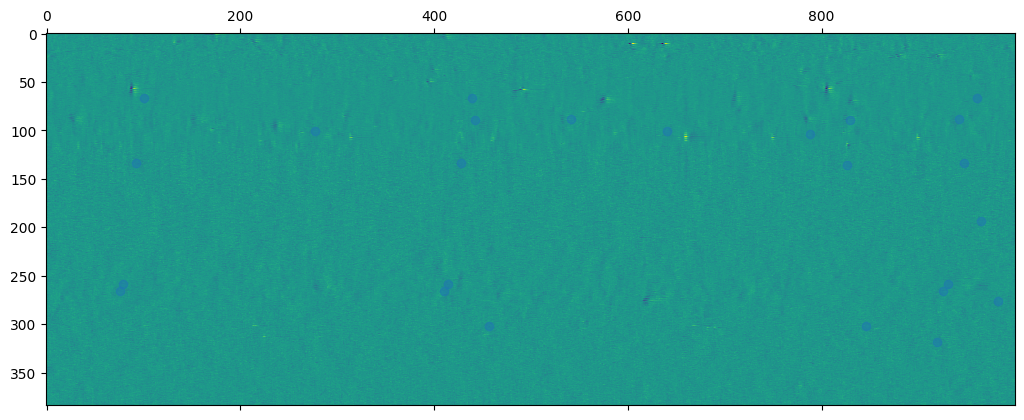

In [100]:
# check out injected templates

import matplotlib.pyplot as plt

s0 = 2000
spikeinds = slice(*np.searchsorted(sorting.to_spike_vector()["sample_index"], [s0, s0+1000]))
clusters = sorting.to_spike_vector()["unit_index"][spikeinds] - 1
channels = peak_channels[clusters]
samples = sorting.to_spike_vector()["sample_index"][spikeinds] - s0
plt.matshow(hybrid.get_traces(0, s0, s0 + 1000).T)
plt.scatter(samples, channels, alpha=0.5)



In [101]:
sorting.to_spike_vector()

memmap([(     2076, 27, 0), (     2079, 36, 0), (     2092, 33, 0), ...,
        (114830562, 17, 0), (114830627,  8, 0), (114830644, 19, 0)],
       dtype=[('sample_index', '<i8'), ('unit_index', '<i8'), ('segment_index', '<i8')])

In [109]:
np.sum(np.isinf(raw))

62

In [ ]:
# look at templates

def trace_plot(arr, ax, channel_range=None, spike_range=None, title=""):
    if spike_range is None:
        spike_range = np.arange(0, 128)
    if channel_range is None:
        channel_range = np.arange(0, 40)
    ax.set_facecolor("#222")
    all_norms = np.linalg.norm(np.abs(arr[spike_range,:]), axis=0)
    max_norm = np.max(all_norms)
    all_norms = np.sqrt(all_norms / max_norm) / 2.
    for i in channel_range:
        y = i + arr[spike_range, i]
        ax.plot(spike_range, y, 
                color = 
                (0.4 + all_norms[i], 0.3 + 0.4*all_norms[i], 0.3 + all_norms[i], .7))
    ax.set_ylim(0, 40)
    ax.set_title(title)

fig, axs = plt.subplots(6, 4, figsize=(16, 9))
for i, ax in enumerate(axs.flat):
    trace_plot(1e5*templates[400+i,:,:].swapaxes(0, 1), ax)
    #fig.colorbar(im, ax=ax, label="amp (uV)")
fig.suptitle("RE templates")